In [1]:
import ml_collections
import torch
import torch.nn as nn
from lightning.pytorch import seed_everything

from seisLM.model.foundation.quantizer import Wav2Vec2GumbelVectorQuantizer

In [2]:
def get_base_config():
  config = ml_collections.ConfigDict()
  config.num_codevector_groups = 2
  config.num_codevectors_per_group = 320
  config.codevector_dim = 256
  return config


def get_initialized_quantizer(config):
  seed_everything(42)
  quantizer = Wav2Vec2GumbelVectorQuantizer(config)
  quantizer.weight_proj.weight.data.normal_(mean=0.0, std=1)
  quantizer.weight_proj.bias.data.zero_()
  nn.init.uniform_(quantizer.codevectors)
  return quantizer


BATCH_SIZE = 1
SEQ_LEN = 100
FEATURE_DIMS = [2**i for i in range(3, 10)]
print(FEATURE_DIMS)

[8, 16, 32, 64, 128, 256, 512]


In [3]:
scale_logits_in_quantization = False

perplexities_no_scale = []
for feature_dim in FEATURE_DIMS:
  config = get_base_config()
  config.scale_logits_in_quantization = scale_logits_in_quantization
  config.conv_dim = [feature_dim]
  quantizer = get_initialized_quantizer(config)

  hidden_states = torch.randn(BATCH_SIZE, SEQ_LEN, feature_dim)
  mask_time_indices = torch.ones(BATCH_SIZE, SEQ_LEN).bool()

  with torch.no_grad():
    codevectors, codevector_perplexity = quantizer(
      hidden_states, mask_time_indices
    )

  num_codevectors = (
    config.num_codevectors_per_group * config.num_codevector_groups
  )

  diversity_loss = (num_codevectors - codevector_perplexity) / num_codevectors

  print(feature_dim, codevector_perplexity, diversity_loss)
  perplexities_no_scale.append(codevector_perplexity)

Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42


8 tensor(370.2291) tensor(0.4215)
16 tensor(314.6315) tensor(0.5084)
32 tensor(283.1690) tensor(0.5575)
64 tensor(247.8835) tensor(0.6127)
128 tensor(243.3735) tensor(0.6197)
256 tensor(208.4332) tensor(0.6743)
512 tensor(185.7116) tensor(0.7098)


In [4]:
scale_logits_in_quantization = True
perplexities_scale = []

for feature_dim in FEATURE_DIMS:
  config = get_base_config()
  config.scale_logits_in_quantization = scale_logits_in_quantization
  config.conv_dim = [feature_dim]
  quantizer = get_initialized_quantizer(config)

  hidden_states = torch.randn(BATCH_SIZE, SEQ_LEN, feature_dim)
  mask_time_indices = torch.ones(BATCH_SIZE, SEQ_LEN).bool()

  with torch.no_grad():
    codevectors, codevector_perplexity = quantizer(
      hidden_states, mask_time_indices
    )

  num_codevectors = (
    config.num_codevectors_per_group * config.num_codevector_groups
  )

  diversity_loss = (
    num_codevectors - codevector_perplexity
  ) / num_codevectors  # * mask_time_indices.sum() #

  perplexities_scale.append(codevector_perplexity)
  print(feature_dim, codevector_perplexity, diversity_loss)

Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42


8 tensor(620.1626) tensor(0.0310)
16 tensor(627.4341) tensor(0.0196)
32 tensor(629.5909) tensor(0.0163)
64 tensor(632.7233) tensor(0.0114)
128 tensor(634.9413) tensor(0.0079)
256 tensor(634.3645) tensor(0.0088)
512 tensor(634.1373) tensor(0.0092)


In [5]:
def simpleaxis(ax):
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.get_xaxis().tick_bottom()
  ax.get_yaxis().tick_left()


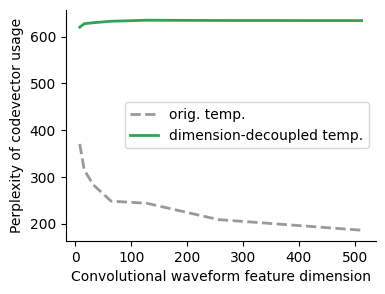

In [9]:
import matplotlib.pyplot as plt

from seisLM.utils import project_path

# matplotlib.font_manager._rebuild()
# plt.rcParams["font.family"] = "Times New Roman"


fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(
  FEATURE_DIMS,
  perplexities_no_scale,
  label="orig. temp.",
  color="#999999",
  ls="--",
  lw=2,
)
ax.plot(
  FEATURE_DIMS,
  perplexities_scale,
  label="dimension-decoupled temp.",
  color="#31a354",
  lw=2,
)
ax.set_xlabel("Convolutional waveform feature dimension")
ax.set_ylabel("Perplexity of codevector usage")
ax.legend()
simpleaxis(ax)

fig.savefig(project_path.FIGURE_DIR + "/dimension_decoupled_temp.pdf")
